In [2]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [13]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'fac_meank',
            'klin']


def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_7',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__1__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_all.8__all.8__all.8',
                          'wgt_flux_2',
                          'wgt_k_0',
                          'crd_10e4745',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [7]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_7',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__1__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_all.8__all.8__all.8',
                          'wgt_flux_2',
                          'wgt_k_0',
                          'crd_10e4745',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(range(1, 7 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [14]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1380

nband = 520

nv = 200

dv = 0.005

tsfc = 294.0

ng = 8

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   1,   4 /)

data wgt
     &     /.8, .8, .8,
     &     .8, 
     &     .8, .8, .8, .8/

option_wgt_flux = 2

option_wgt_k = 0

klin = 1e-100

include 'mls75.pro'


In [15]:
fig.display_hrefanchor()

In [16]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [17]:
table_dgdgs.display_hrefanchor()

In [18]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [19]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [20]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

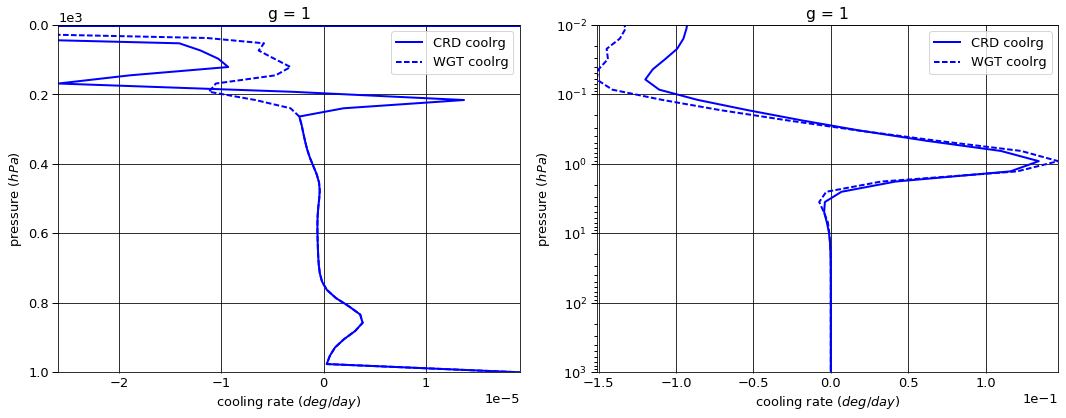

# Figure: cooling rate g-group 2

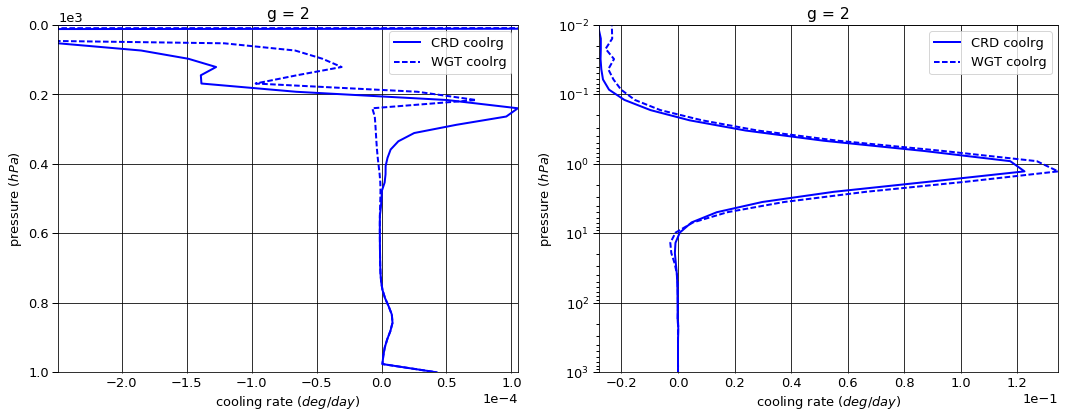

# Figure: cooling rate g-group 3

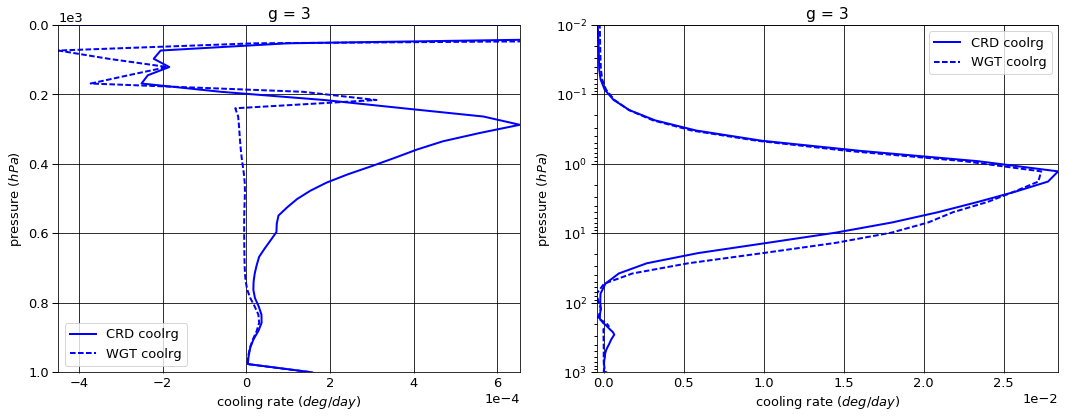

# Figure: cooling rate g-group 4

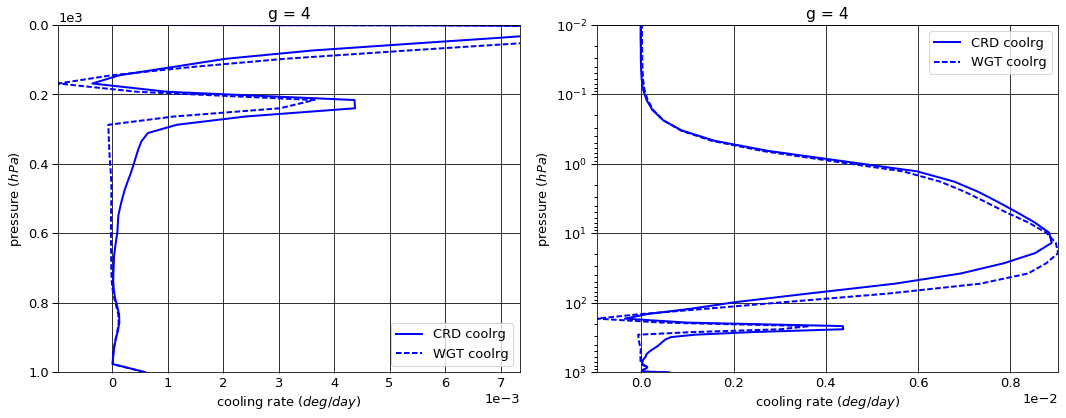

# Figure: cooling rate g-group 5

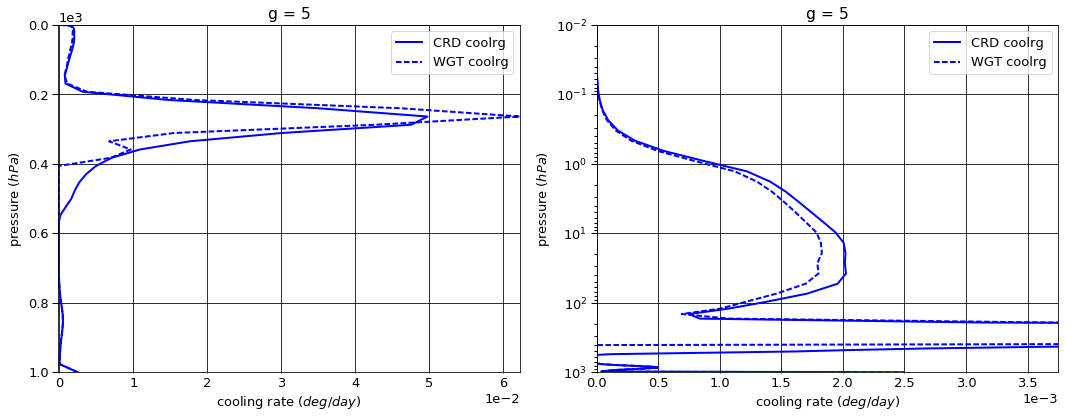

# Figure: cooling rate g-group 6

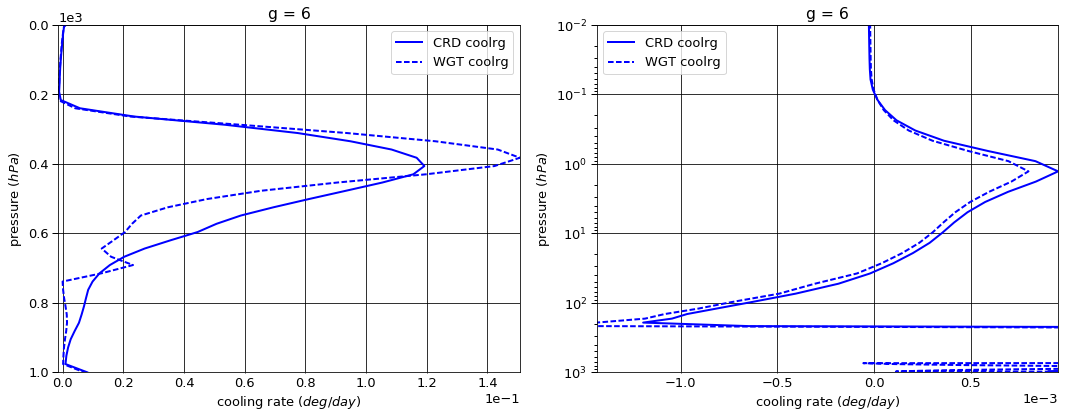

# Figure: cooling rate g-group 7

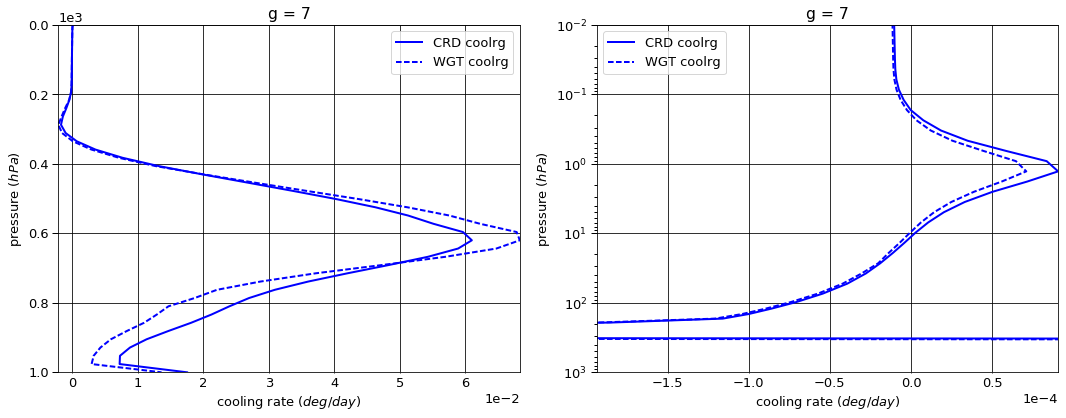

# Figure: cooling rate g-group total

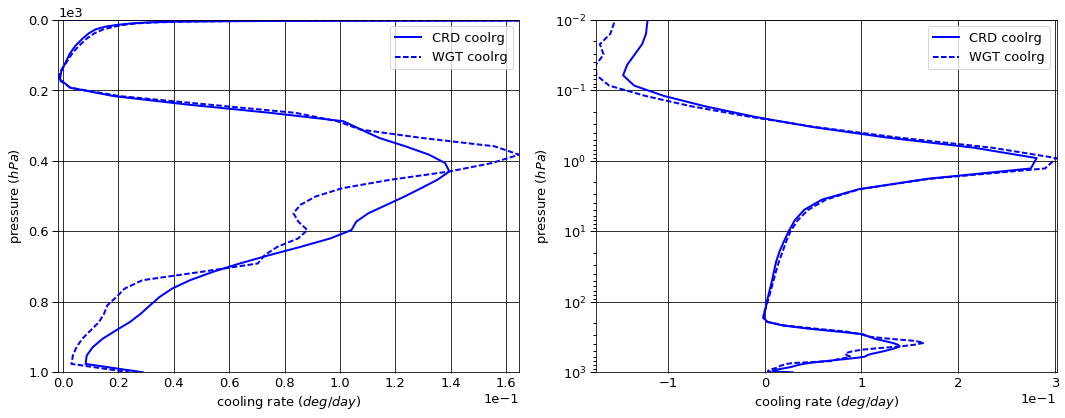

In [21]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [22]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.013192   0.000000 -0.013192
  1013.0   76     -0.046136   0.046083 -0.000054
2 0.0      1      -0.029752   0.000000 -0.029752
  1013.0   76     -0.102373   0.102254 -0.000119
3 0.0      1      -0.052776   0.000000 -0.052776
  1013.0   76     -0.374788   0.374348 -0.000440
4 0.0      1      -0.124961   0.000000 -0.124961
  1013.0   76     -1.449447   1.447752 -0.001696
5 0.0      1      -0.702903   0.000000 -0.702903
  1013.0   76     -6.015176   6.008190 -0.006987
6 0.0      1      -3.924786   0.000000 -3.924786
  1013.0   76    -17.079470  17.057838 -0.021632
7 0.0      1      -2.426531   0.000000 -2.426531
  1013.0   76     -5.662107   5.600216 -0.061891
8 0.0      1      -0.000081   0.000000 -0.000081
  1013.0   76     -0.000118   0.000101 -0.000017


WGT


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.011994   0.000000 -0.011994
  1013.0   76     -0.046136   0.046083 -0.000054
2 0.0      1      -0.033029   0.000000 -0.033029
  1013.0   76     -0.102373   0.102254 -0.000119
3 0.0      1      -0.049069   0.000000 -0.049069
  1013.0   76     -0.374788   0.374351 -0.000436
4 0.0      1      -0.111154   0.000000 -0.111154
  1013.0   76     -1.449447   1.447763 -0.001685
5 0.0      1      -0.643324   0.000000 -0.643324
  1013.0   76     -6.015176   6.008190 -0.006987
6 0.0      1      -3.548722   0.000000 -3.548722
  1013.0   76    -17.079470  17.059644 -0.019826
7 0.0      1      -2.293550   0.000000 -2.293550
  1013.0   76     -5.662107   5.625507 -0.036600
8 0.0      1      -0.000081   0.000000 -0.000081
  1013.0   76     -0.000118   0.000101 -0.000017


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001198  0.000000  0.001198
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1     -0.003276  0.000000 -0.003276
  1013.0   76     0.000000  0.000000  0.000000
3 0.0      1      0.003706  0.000000  0.003706
  1013.0   76     0.000000  0.000004  0.000004
4 0.0      1      0.013807  0.000000  0.013807
  1013.0   76     0.000000  0.000011  0.000011
5 0.0      1      0.059579  0.000000  0.059579
  1013.0   76     0.000000  0.000000  0.000000
6 0.0      1      0.376064  0.000000  0.376064
  1013.0   76     0.000000  0.001806  0.001806
7 0.0      1      0.132981  0.000000  0.132981
  1013.0   76     0.000000  0.025291  0.025291
8 0.0      1      0.000000  0.000000  0.000000
  1013.0   76     0.000000  0.000000  0.000000

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.072935e-01
  1001.112500 75     1.915468e-05
2 0.000312    1     -2.832892e-02
  1001.112500 75     4.238868e-05
3 0.000312    1     -4.942825e-04
  1001.112500 75     1.574422e-04
4 0.000312    1     -3.655211e-05
  1001.112500 75     6.059310e-04
5 0.000312    1     -1.488781e-06
  1001.112500 75     2.491786e-03
6 0.000312    1     -3.300586e-05
  1001.112500 75     8.069904e-03
7 0.000312    1     -1.125630e-05
  1001.112500 75     1.750903e-02
8 0.000312    1     -1.099379e-15
  1001.112500 75     1.860318e-06


WGT


coolrg
g pressure    layer              
1 0.000312    1     -1.481394e-01
  1001.112500 75     1.915468e-05
2 0.000312    1     -2.209597e-02
  1001.112500 75     4.238868e-05
3 0.000312    1     -3.410553e-04
  1001.112500 75     1.556595e-04
4 0.000312    1      3.453432e-06
  1001.112500 75     6.008177e-04
5 0.000312    1     -3.454010e-07
  1001.112500 75     2.491786e-03
6 0.000312    1     -2.565119e-05
  1001.112500 75     7.070806e-03
7 0.000312    1     -1.218548e-05
  1001.112500 75     1.360844e-02
8 0.000312    1     -1.099379e-15
  1001.112500 75     1.860318e-06


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.084591e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      6.232950e-03
  1001.112500 75     0.000000e+00
3 0.000312    1      1.532272e-04
  1001.112500 75    -1.782730e-06
4 0.000312    1      4.000554e-05
  1001.112500 75    -5.113380e-06
5 0.000312    1      1.143380e-06
  1001.112500 75     0.000000e+00
6 0.000312    1      7.354675e-06
  1001.112500 75    -9.990987e-04
7 0.000312    1     -9.291730e-07
  1001.112500 75    -3.900595e-03
8 0.000312    1      0.000000e+00
  1001.112500 75     0.000000e+00

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.274982,0.000000,-7.274982
1013.0,76,-30.729616,30.636781,-0.092836



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.690923,0.000000,-6.690923
1013.0,76,-30.729616,30.663893,-0.065724



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.584059,0.000000,0.584059
1013.0,76,0.000000,0.027112,0.027112


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.136199
1001.112500,75,0.028898



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.170611
1001.112500,75,0.023991



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.034412
1001.112500,75,-0.004907


In [23]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001452,0.001495
2,0.003240,0.003333
3,0.011856,0.012140
4,0.045250,0.047069
5,0.186990,0.195494
6,0.543010,0.556468
7,0.208192,0.183999
8,0.000010,0.000003


In [24]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.887171e-18
2,1.278086e-19
3,5.657798e-21
4,2.489067e-21
5,5.350613e-21
6,2.411227e-22
7,1.086608e-23
8,1.000000e+00


In [27]:
def spreadsheet():
    ng = 8
    ng_refs = [3, 1, 4]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [28]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.887171e-18,NaN,0.001452,0.001495,0.001452,0.001495,1.0
2,1.278086e-19,4.426775e-02,0.003240,0.003333,0.004692,0.004828,1.0
3,5.657798e-21,4.426775e-02,0.011856,0.012140,0.016548,0.016968,1.0
4,2.489067e-21,4.399356e-01,0.045250,0.047069,0.061798,0.064037,10.0
5,5.350613e-21,2.149646e+00,0.186990,0.195494,0.248788,0.259531,500.0
6,2.411227e-22,4.506451e-02,0.543010,0.556468,0.791798,0.815999,500.0
7,1.086608e-23,4.506451e-02,0.208192,0.183999,0.999990,0.999997,500.0
8,1.000000e+00,9.202953e+22,0.000010,0.000003,1.000000,1.000000,500.0


In [29]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [30]:
#pd.set_option('display.max_rows', None)
#display.display(
#    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
#                index_col=[0, 1],
#                sep=r'\s+')
#    )
#pd.reset_option('display.max_rows')

# Histogram of wavenumbers in g-group 1

In [31]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [32]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
